## Dependencies

#### Note: All libraries can be installed using pip

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error as MAE, mean_squared_error as MSE

from tqdm import trange, tqdm
import tqdm.notebook as tq

import warnings
warnings.filterwarnings("ignore")

## Datasets

In [2]:
data_batting_scorecard = pd.read_csv("./datasets/match_scores_batting.csv")
data_bbb = pd.read_csv("./datasets\match_ball_events.csv")
data_fow = pd.read_csv("./datasets/match_scores_fow.csv")
data_match_innings = pd.read_csv("./datasets/match_innings.csv")
data_players = pd.read_csv("./datasets/players.csv")

## Helper Functions

In [3]:
def true_match_realization_of_player(player_pkey, match_pkey, inn_num):
    
    COLUMNS = ['pkey', 'match_pkey', 'over_num', 'ball_num', 'runs_batsman', 'innings', 'is_dismissal', \
           'dismissal_type', 'dismissed_player_pkey', 'batsman_pkey', 'bowler_pkey']
    
    player_data = data_bbb[(data_bbb['match_pkey']==match_pkey) &
                         (data_bbb['innings']==inn_num) &
                         (data_bbb['batsman_pkey']==player_pkey) &
                         (data_bbb['is_dismissal']==0)][COLUMNS]
    
    return list(player_data['runs_batsman'])

In [4]:
def input_from_scorecard(match_pkey, inn_num):

    COLUMNS = ['match_pkey', 'innings', 'position', 'status', 'player_pkey', \
               'runs', 'balls', 'fours', 'sixes', 'is_dismissed', 'dismissal', 'bowler_pkey']

    data_innings = data_batting_scorecard[(data_batting_scorecard['match_pkey']==match_pkey) & 
                                          (data_batting_scorecard['innings']==inn_num) & 
                                          (data_batting_scorecard['status'] != 'DNB')][COLUMNS]

    batting_order = dict(zip(data_innings['position'].astype(int), data_innings['player_pkey']))

    batsman_data = {}

    for index, row in data_innings.iterrows():
            
        player_pkey = row['player_pkey']

        values = {'runs': int(row['runs']), 
                  'balls_faced': int(row['balls']), 
                  'fours': int(row['fours']), 
                  'sixes': int(row['sixes'])}
            
        if row['is_dismissed'] == 0 and row['dismissal'] != 'runout':
            values['balls_faced'] -= 1
        
        batsman_data[player_pkey] = values
    
    true_batsman_realizations = {}
    
    for key in batting_order.values():
        true_batsman_realizations[key] = true_match_realization_of_player(key, match_pkey, inn_num)
        
    batsman_data = pd.DataFrame.from_dict(batsman_data)

    return data_innings, batting_order, batsman_data, true_batsman_realizations

In [5]:
def input_from_fow(match_pkey, inn_num):
    
    temp_data = data_fow[(data_fow['match_pkey']==match_pkey) & (data_fow['innings']==inn_num)]
    
    fow_balls = dict(zip(temp_data['player_pkey'], temp_data['balls_at_dismissal'].astype(int)))
    fow_score = dict(zip(temp_data['player_pkey'], temp_data['score_at_dismissal'].astype(int)))
    fow_type = dict(zip(temp_data['player_pkey'], temp_data['dismissal']))
    
    fow_player_at_ball = dict(zip(temp_data['balls_at_dismissal'].astype(int), temp_data['player_pkey']))
    
    cols = ['match_pkey', 'innings', 'number', 'player_pkey', 'dismissal', 'balls_at_dismissal', 'score_at_dismissal']
    return temp_data[cols], fow_balls, fow_score, fow_type, fow_player_at_ball

In [6]:
def partnership_segments(match_pkey, inn_num):
    
    temp_data = data_fow[(data_fow['match_pkey']==match_pkey) & (data_fow['innings']==inn_num)]
    
    temp0 = dict(zip(temp_data['player_pkey'], temp_data['balls_at_dismissal'].astype(int)))
    wicket_balls = list(temp0.values())
    
    temp1 = wicket_balls.copy()    
    temp1.insert(0,1)
    
    last_ball = int(data_match_innings[(data_match_innings['match_pkey']==match_pkey) & (data_match_innings['inn_num']==inn_num)]['balls'])
    
    if temp1[-1] != last_ball and temp_data.shape[0]!=10:
        temp1.append(last_ball)

    segments = [(temp1[i], temp1[i + 1]) for i in range(len(temp1)-1)]
    
    for idx, ele in enumerate(segments):
        if idx == 0:
            if len(segments) != 1:
                segments[0] = (segments[0][0], segments[0][1]-1)
        elif idx == len(segments)-1:
            if 120 in wicket_balls:
                segments[-1] = (segments[-1][0]+1, segments[-1][1]-1)
            else:
                segments[-1] = (segments[-1][0]+1, segments[-1][1])
        else:
            segments[idx] = (segments[idx][0]+1, segments[idx][1]-1)
            
    return segments

In [7]:
def find_pair_batting_in_each_segment(segments, batting_order, fow_player_at_ball):
    pair_at_each_segment = []
    next_batsman_idx = 0
    
    if len(segments) == 1:
        pair_at_each_segment.append((batting_order[1], batting_order[2]))
        return pair_at_each_segment

    for idx in range(len(segments)):
        segment = segments[idx]

        if idx == 0:
            pair_at_each_segment.append((batting_order[1], batting_order[2]))
            player_dismissed = fow_player_at_ball[segment[1]+1]
            next_batsman_idx = 3

        try:
            player_dismissed = fow_player_at_ball[segment[1]+1]
        except KeyError:
            break

        if pair_at_each_segment[-1][0] == player_dismissed:
            player_not_dismissed = pair_at_each_segment[-1][1]
        else:
            player_not_dismissed = pair_at_each_segment[-1][0]

        if next_batsman_idx <= len(batting_order):
            next_batsman = batting_order[next_batsman_idx]
            next_batsman_idx += 1

        pair_at_each_segment.append((player_not_dismissed, next_batsman))
        
    return pair_at_each_segment    

In [8]:
def segment_runs(fow_score, fow_balls, match_pkey, inn_num):
    temp1 = list(fow_score.values())
    temp1.insert(0,0)

    final_score = int(data_match_innings[(data_match_innings['match_pkey']==match_pkey) & (data_match_innings['inn_num']==inn_num)]['runs'])
    if 120 in fow_balls.values():
        temp1[-1] = final_score
    else:
        temp1.append(final_score)

    temp1.sort()
    temp1 = [(temp1[i+1]-temp1[i]) for i in range(len(temp1)-1)]

    return temp1

In [9]:
def create_segment_wise_player_data(match_pkey, inn_num, segments, pair_at_each_segment,
                                    batsman_data, fow_score, fow_balls, batting_order):
    temp = batsman_data.copy()
    partnership_data = {}

    for idx in range(1, len(segments)+1):
         partnership_data[idx] = {'segment': segments[idx-1], 'pair': pair_at_each_segment[idx-1]}

    partnership_data = pd.DataFrame.from_dict(partnership_data).T
    
    seg_runs = segment_runs(fow_score, fow_balls, match_pkey, inn_num)
    
    if len(seg_runs) >= partnership_data.shape[0]:
        seg_runs = seg_runs[:partnership_data.shape[0]]
    partnership_data['segment_runs'] = seg_runs
    
    partnership_data['segment_balls'] = partnership_data['segment'].apply(lambda ele: (ele[1]-ele[0]+1))
    
    if len(segments) == 1: # Wickets Fallen = 0
        player_B1, player_B2 = partnership_data['pair'][1][0], partnership_data['pair'][1][1]
        partnership_data['dismissed_player (B1)'] = player_B1
        partnership_data['not_dismissed_player (B2)'] = player_B2
        
        partnership_data['B1_runs'] = temp[player_B1]['runs']
        partnership_data['B1_balls'] = temp[player_B1]['balls_faced']
        partnership_data['B1_fours'] = temp[player_B1]['fours']
        partnership_data['B1_sixes'] = temp[player_B1]['sixes']
        partnership_data['B2_runs'] = temp[player_B2]['runs']
        partnership_data['B2_balls'] = temp[player_B2]['balls_faced']
        partnership_data['B2_fours'] = temp[player_B2]['fours']
        partnership_data['B2_sixes'] = temp[player_B2]['sixes']
        
        temp[player_B1]['runs'] -= temp[player_B1]['runs']
        temp[player_B1]['balls_faced'] -= temp[player_B1]['balls_faced']
        temp[player_B2]['runs'] -= temp[player_B2]['runs']
        temp[player_B2]['balls_faced'] -= temp[player_B2]['balls_faced']
        
        partnership_data['Extras'] = partnership_data['segment_runs'][1] - partnership_data['B1_runs'][1] - partnership_data['B2_runs'][1]
        partnership_data['Wide/NB'] = partnership_data['B1_balls'][1] + partnership_data['B2_balls'][1] - partnership_data['segment_balls'][1]
        
        return partnership_data, temp
        
    num_segments = partnership_data.shape[0]
    dismissed_players, not_dismissed_players = [], []

    for idx in range(1,num_segments):
        pair = partnership_data['pair'][idx]
        next_pair = partnership_data['pair'][idx+1]

        dismissed_player = set(pair) - set(next_pair)
        dismissed_players.append(dismissed_player.pop())

        not_dismissed_player = set(pair).intersection(set(next_pair))
        not_dismissed_players.append(not_dismissed_player.pop())

        if idx == num_segments-1:
            dismissed_player = not_dismissed_players[-1]
            dismissed_players.append(dismissed_player)
            not_dismissed_player = set(next_pair) - set([dismissed_player])
            try:
                not_dismissed_players.append(not_dismissed_player.pop())
            except:
                pass
            
    partnership_data['dismissed_player (B1)'] = dismissed_players
    partnership_data['not_dismissed_player (B2)'] = not_dismissed_players
    
    runs_B1, runs_B2 = [], []
    balls_B1, balls_B2 = [], []
    extras = []

    for idx, row in partnership_data.iterrows():
        player_B1, player_B2 = row['dismissed_player (B1)'], row['not_dismissed_player (B2)']

        if idx != partnership_data.shape[0]:
            # player B1
            temp_runs_B1, temp_balls_B1 = temp[player_B1]['runs'], temp[player_B1]['balls_faced']
            temp[player_B1]['runs'] -= temp_runs_B1
            temp[player_B1]['balls_faced'] -= temp_balls_B1

            # player B2
            if row['segment_runs'] - temp_runs_B1 > temp[player_B2]['runs']:
                temp_runs_B2 = temp[player_B2]['runs']
                temp_balls_B2 = row['segment_balls'] - temp_balls_B1
                temp[player_B2]['runs'] -= temp_runs_B2
                temp[player_B2]['balls_faced'] -= temp_balls_B2
                extras.append(row['segment_runs'] - temp_runs_B2 - temp_runs_B1)
            else:
                temp_runs_B2 = row['segment_runs'] - temp_runs_B1
                temp_balls_B2 = row['segment_balls'] - temp_balls_B1
                temp[player_B2]['runs'] -= temp_runs_B2
                temp[player_B2]['balls_faced'] -= temp_balls_B2
                extras.append(0)

        else: # last partnership
            # player B2
            temp_runs_B2, temp_balls_B2 = temp[player_B2]['runs'], temp[player_B2]['balls_faced']
            temp[player_B2]['runs'] -= temp_runs_B2
            temp[player_B2]['balls_faced'] -= temp_balls_B2

            # player B1
            if row['segment_runs'] - temp_runs_B2 > temp[player_B1]['runs']:
                temp_runs_B1 = temp[player_B1]['runs']
                temp_balls_B1 = row['segment_balls'] - temp_balls_B2
                temp[player_B1]['runs'] -= temp_runs_B1
                temp[player_B1]['balls_faced'] -= temp_balls_B1
                extras.append(row['segment_runs'] - temp_runs_B1 - temp_runs_B2)
            else:
                temp_runs_B1 = row['segment_runs'] - temp_runs_B2
                temp_balls_B1 = row['segment_balls'] - temp_balls_B2
                temp[player_B1]['runs'] -= temp_runs_B1
                temp[player_B1]['balls_faced'] -= temp_balls_B1
                extras.append(0)

        # append to list
        runs_B1.append(temp_runs_B1)
        runs_B2.append(temp_runs_B2)
        balls_B1.append(temp_balls_B1)
        balls_B2.append(temp_balls_B2)

    partnership_data['B1_runs'] = runs_B1
    partnership_data['B1_balls'] = balls_B1

    partnership_data['B2_runs'] = runs_B2
    partnership_data['B2_balls'] = balls_B2
    
    partnership_data['Extras'] = extras
    partnership_data['Wide/NB'] = [0]*len(segments)
    
    # managing deficit balls
    player_temp = partnership_data.iloc[-1]['dismissed_player (B1)']
    deficit_balls = temp[player_temp]['balls_faced']
   
    index_B1 = list(partnership_data[partnership_data['dismissed_player (B1)']==player_temp].index)
    index_B2 = list(partnership_data[partnership_data['not_dismissed_player (B2)']==player_temp].index)

    while deficit_balls > 0:
        if len(index_B1) == 0 and len(index_B2) == 0:
            break
            
        if len(index_B1) > 0:
            for idx in index_B1:
                partnership_data.loc[idx, 'B1_balls'] += 1
                partnership_data.loc[idx, 'Wide/NB'] += 1
                temp[player_temp]['balls_faced'] -= 1
                deficit_balls -= 1

                if deficit_balls == 0:
                    break
                    
        if deficit_balls == 0:
            break

        if len(index_B2) > 0:
            for idx in index_B2:
                partnership_data.loc[idx, 'B2_balls'] += 1
                partnership_data.loc[idx, 'Wide/NB'] += 1
                temp[player_temp]['balls_faced'] -= 1
                deficit_balls -= 1

                if deficit_balls == 0:
                    break
                    
    # distributing fours and sixes per player into different segments randomly under cricketing constraints
    partnership_data['B1_fours'] = [0]*partnership_data.shape[0]
    partnership_data['B1_sixes'] = [0]*partnership_data.shape[0]
    partnership_data['B2_fours'] = [0]*partnership_data.shape[0]
    partnership_data['B2_sixes'] = [0]*partnership_data.shape[0]

    players = list(batting_order.values())

    for player_pkey in players:
        temp_B1_index = list(partnership_data[partnership_data['dismissed_player (B1)']==player_pkey].index)
        temp_B2_index = list(partnership_data[partnership_data['not_dismissed_player (B2)']==player_pkey].index)
        B1_index_sixes, B2_index_sixes = [], []
        B1_index_fours, B2_index_fours = [], [] 
               
        # randomly distributing sixes
        for idx in temp_B1_index:
            row = partnership_data[partnership_data.index == idx]
            if row['B1_runs'].iloc[0] >= 6 and row['B1_balls'].iloc[0] > 0:
                B1_index_sixes.append(idx)

        for idx in temp_B2_index:
            row = partnership_data[partnership_data.index == idx]
            if row['B2_runs'].iloc[0] >= 6 and row['B2_balls'].iloc[0] > 0:
                B2_index_sixes.append(idx)

        sixes_index = B1_index_sixes + B2_index_sixes
        
        while temp[player_pkey]['sixes'] > 0 and len(sixes_index) > 0:
            # choose random segment
#             sixes_index = B1_index_sixes + B2_index_sixes
            rand_idx = np.random.choice(sixes_index)
            
#             print('sixes section')
            if rand_idx in B1_index_sixes:
                row = partnership_data[partnership_data.index == rand_idx]
                if (row['B1_runs'].iloc[0] - 6*(row['B1_sixes'].iloc[0] + 1) >= 0) and \
                    (row['B1_balls'].iloc[0] - (row['B1_sixes'].iloc[0] + 1) >= 0):
                    partnership_data.loc[rand_idx, 'B1_sixes'] += 1
                else:
                    B1_index_sixes.remove(rand_idx)

            elif rand_idx in B2_index_sixes:
                row = partnership_data[partnership_data.index == rand_idx]
                if (row['B2_runs'].iloc[0] - 6*(row['B2_sixes'].iloc[0] + 1) >= 0) and \
                    (row['B2_balls'].iloc[0] - (row['B2_sixes'].iloc[0] + 1) >= 0):
                    partnership_data.loc[rand_idx, 'B2_sixes'] += 1
                else:
                    B2_index_sixes.remove(rand_idx)
                    
            temp[player_pkey]['sixes'] -= 1
            sixes_index = B1_index_sixes + B2_index_sixes


        # randomly distributing fours
        for idx in temp_B1_index:
            row = partnership_data[partnership_data.index == idx]
            temp_B1_runs = row['B1_runs'].iloc[0] - (6*row['B1_sixes'].iloc[0])
            temp_B1_balls = row['B1_balls'].iloc[0] - row['B1_sixes'].iloc[0]

            if temp_B1_runs >= 4 and temp_B1_balls > 0:
                B1_index_fours.append(idx)

        for idx in temp_B2_index:
            row = partnership_data[partnership_data.index == idx]
            temp_B2_runs = row['B2_runs'].iloc[0] - (6*row['B2_sixes'].iloc[0])
            temp_B2_balls = row['B2_balls'].iloc[0] - row['B2_sixes'].iloc[0]

            if temp_B2_runs >= 4 and temp_B2_balls > 0:
                B2_index_fours.append(idx)

        fours_index = B1_index_fours + B2_index_fours
        
#         print('pkey', player_pkey, 'temp_pla_fours', temp[player_pkey]['fours'],
#               'sixes_index', sixes_index, 'B1_index_sixes', B1_index_sixes, 'B2_index_sixes', B2_index_sixes,
#               'fours_index', fours_index, 'B1_index_fours', B1_index_fours, 'B2_index_fours', B2_index_fours)
        
        while temp[player_pkey]['fours'] > 0 and len(fours_index) > 0:

            # choose random segment
#             fours_index = B1_index_fours + B2_index_fours
            rand_idx = np.random.choice(fours_index)
            
#             print('fours section')
            if rand_idx in B1_index_fours:
                row = partnership_data[partnership_data.index == rand_idx]
                temp_B1_runs = row['B1_runs'].iloc[0] - 6*(row['B1_sixes'].iloc[0])
                temp_B1_balls = row['B1_balls'].iloc[0] - row['B1_sixes'].iloc[0]

                if (temp_B1_runs - 4*(row['B1_fours'].iloc[0] + 1) >= 0) and \
                    (temp_B1_balls - (row['B1_fours'].iloc[0] + 1) >= 0):
                    partnership_data.loc[rand_idx, 'B1_fours'] += 1
                else:
                    B1_index_fours.remove(rand_idx)

            elif rand_idx in B2_index_fours:
                row = partnership_data[partnership_data.index == rand_idx]
                temp_B2_runs = row['B2_runs'].iloc[0] - 6*(row['B2_sixes'].iloc[0])
                temp_B2_balls = row['B2_balls'].iloc[0] - row['B2_sixes'].iloc[0]

                if (temp_B2_runs - 4*(row['B2_fours'].iloc[0] + 1) >= 0) and \
                    (temp_B2_balls - (row['B2_fours'].iloc[0] + 1) >= 0):
                    partnership_data.loc[rand_idx, 'B2_fours'] += 1
                else:
                    B2_index_fours.remove(rand_idx)

            temp[player_pkey]['fours'] -= 1
            fours_index = B1_index_fours + B2_index_fours

    return partnership_data, temp

In [10]:
def val_partnership_breakdown(partnership_data, batting_order):
    val_batsman_data = {}

    for player_pkey in batting_order.values():
        player_runs, player_balls, player_fours, player_sixes = 0, 0, 0, 0
        B1_index = list(partnership_data[partnership_data['dismissed_player (B1)'] == player_pkey].index)
        B2_index = list(partnership_data[partnership_data['not_dismissed_player (B2)'] == player_pkey].index)

        for idx in B1_index:
            row = partnership_data[partnership_data.index == idx]
            player_runs += row['B1_runs'].iloc[0]
            player_balls += row['B1_balls'].iloc[0]
            player_fours += row['B1_fours'].iloc[0]
            player_sixes += row['B1_sixes'].iloc[0]

        for idx in B2_index:
            row = partnership_data[partnership_data.index == idx]
            player_runs += row['B2_runs'].iloc[0]
            player_balls += row['B2_balls'].iloc[0]
            player_fours += row['B2_fours'].iloc[0]
            player_sixes += row['B2_sixes'].iloc[0]

        val_batsman_data[player_pkey] = {'runs':player_runs,
                                         'balls_faced':player_balls,
                                         'fours':player_fours,
                                         'sixes':player_sixes}

    val_batsman_data = pd.DataFrame.from_dict(val_batsman_data).T

    COLUMNS = ['runs', 'balls_faced', 'fours', 'sixes']
    
    return val_batsman_data[COLUMNS]

In [11]:
def modify_realization_at_values(realization, tot_runs, value):
    
    if sum(realization) == tot_runs:
        return realization
    
    while sum(realization) < tot_runs and realization.count(value) > 0:
        
        indexes_value = [i for i, j in enumerate(realization) if j == value]
        rand_idx = np.random.choice(indexes_value)
        
        if value == 0:
            if tot_runs - sum(realization) >= 2:
                realization[rand_idx] = 2
            else:
                realization[rand_idx] = 1
                
        elif value == 1:
            realization[rand_idx] = 2
    
    return realization

In [12]:
def simulate_player(data, commentary=False):
    
    data['rem_runs'] = data['runs']
    data['rem_balls'] = data['balls_faced']

    data['boundary_balls'] = data['fours'] + data['sixes']
    data['non_boundary_balls'] = data['rem_balls'] - data['boundary_balls']

    data['runs_bb'] = 4*data['fours'] + 6*data['sixes']  
    data['runs_non_bb'] = data['rem_runs'] - data['runs_bb']

    data['prob_bb'] = round(data['boundary_balls']/data['rem_balls'], 2)
    data['prob_non_bb'] = 1 - data['prob_bb']
    
    data['rand_num'] = -1
    data['check_bb'] = -1
    data['random_outcome'] = -1
    
    history = pd.DataFrame(data, index=[0])
    
    boundaries = data['fours']*[4] + data['sixes']*[6]

    idx = 0
    boundary_permuted = np.random.permutation(boundaries)
    
    if commentary:
        print('Boundary permutation', boundary_permuted)
        print('\nSimulation:')

    realization = []

    while data['rem_balls'] > 0:

#         if data['boundary_balls'] == 0:
#             outcome = 'No Boundary'
#             data['check_bb'] = 0
#         elif data['non_boundary_balls'] == 0:
#             outcome = 'Boundary'
#             data['check_bb'] = 1
#         else:

        rand_num = np.random.random()
        data['rand_num'] = rand_num

        if rand_num < data['prob_bb']:
            outcome = 'Boundary'
            data['check_bb'] = 1
        else:
            outcome = 'No Boundary'
            data['check_bb'] = 0

        if outcome == 'Boundary':            
            random_boundary_choice = boundary_permuted[idx]
            idx += 1

            realization.append(random_boundary_choice)
            data['random_outcome'] = random_boundary_choice
            
            ball_outcome = random_boundary_choice

        elif outcome == 'No Boundary':            
            if data['runs_non_bb'] <= 0:
                random_run_choice = 0
            elif data['runs_non_bb'] == 1:
                if data['non_boundary_balls'] == 1:
                    random_run_choice = 1
                else:
                    random_run_choice = np.random.choice([0, 1]) 
            else: # data['runs_non_bb'] >= 2
                if data['non_boundary_balls'] == 1:
                    random_run_choice = 2
                else:
                    random_run_choice = np.random.choice([0,1,2], p=[0.466,0.452,0.082])
#                     random_run_choice = np.random.choice([0,1,2], p=[0.25,0.5,0.25])

            realization.append(random_run_choice)
            data['random_outcome'] = random_run_choice
            
            ball_outcome = random_run_choice
        
        history = history.append(data, ignore_index=True)
        
        data['rem_balls'] -= 1
        data['rem_runs'] -= ball_outcome
        
        if outcome == 'Boundary':
            data['boundary_balls'] -= 1
            data['runs_bb'] -= ball_outcome
        else:
            data['non_boundary_balls'] -= 1
            data['runs_non_bb'] -= ball_outcome
        
        if data['rem_balls'] > 0:
            data['prob_bb'] = round(data['boundary_balls']/data['rem_balls'], 2)
            data['prob_non_bb'] = 1 - data['prob_bb']  
        
        if commentary:
            print('Ball', data['balls_faced']-data['rem_balls'], ':', outcome, ball_outcome)
    
    data['random_outcome'] = -1
    history = history.append(data, ignore_index=True)
    
    if commentary:
        print('Ball',  data['balls_faced']-data['rem_balls']+1, ': Wicket!!!')
        print('\nRealization:', realization)
    
    ## In case sum(realization) != data['runs'], then perform required modifications to satisfy the constraint
    
    if sum(realization) == data['runs']:
#         return realization, history
        return list(np.random.permutation(realization)), history

    if commentary:
        print('sum:', sum(realization), ':: len:', len(realization), ':: 4s:', realization.count(4), ':: 6s:', realization.count(6))
        print('Modification required to satisy sum(realization) = runs_scored')

    realization = modify_realization_at_values(realization, data['runs'], 0)
       
    if sum(realization) == data['runs']:
#         return realization, history
        return list(np.random.permutation(realization)), history
    
    realization = modify_realization_at_values(realization, data['runs'], 1)
       
#     return realization, history
    return list(np.random.permutation(realization)), history

In [13]:
def validate_innings_simulation(innings_outcome):
    players = list(innings_outcome['batsman'].unique())
    validation = {}

    for player_pkey in players:
        player_realization = list(innings_outcome[innings_outcome['batsman']==player_pkey]['outcome'])

        if -1 in player_realization:
            temp_idx = player_realization.index(-1)
            player_realization[temp_idx] = 0

        player_data = {'runs': sum(player_realization),
                       'balls': len(player_realization),
                       'fours': player_realization.count(4),
                       'sixes': player_realization.count(6)}

        validation[player_pkey] = player_data

    validation = pd.DataFrame.from_dict(validation).T
    columns = ['runs', 'balls', 'fours', 'sixes']
    
    return validation[columns] 

In [14]:
def simulate_innings_v0(match_pkey, inn_num, commentary=False):
    
    data_innings, batting_order, batsman_data, true_batsman_realizations = input_from_scorecard(match_pkey, inn_num)
    data_fow, fow_balls, fow_score, fow_type, fow_player_at_ball = input_from_fow(match_pkey, inn_num)
    
    segments = partnership_segments(match_pkey, inn_num)
    pair_at_each_segment = find_pair_batting_in_each_segment(segments, batting_order, fow_player_at_ball)
    
    partnership_data, modified_batsman_data = create_segment_wise_player_data(match_pkey, inn_num, segments,
                                                                          pair_at_each_segment, batsman_data,
                                                                          fow_score, fow_balls, batting_order)
    
    ball_num, batsmen_pkey, ball_outcome = [], [], []

    for idx, row in partnership_data.iterrows():

        row = partnership_data[partnership_data.index == idx]
        segment = row['segment'].iloc[0]
        start, end = segment[0], segment[1]
        
        if commentary:
            print('idx:', idx, 'segment:', segment)

        if end-start+1 == 0:
            ball_num.append(start)
            batsmen_pkey.append(fow_player_at_ball[start])
            ball_outcome.append(-1)
            continue

        # player B1
        player_B1_key = row['dismissed_player (B1)'].iloc[0]
        player_B1_data = {'runs': row['B1_runs'].iloc[0],
                          'balls_faced': row['B1_balls'].iloc[0],
                          'fours': row['B1_fours'].iloc[0],
                          'sixes': row['B1_sixes'].iloc[0]}

        player_B1_realization, player_B1_history = simulate_player(player_B1_data)

        # player B2
        player_B2_key = row['not_dismissed_player (B2)'].iloc[0]
        player_B2_data = {'runs': row['B2_runs'].iloc[0],
                          'balls_faced': row['B2_balls'].iloc[0],
                          'fours': row['B2_fours'].iloc[0],
                          'sixes': row['B2_sixes'].iloc[0]}

        player_B2_realization, player_B2_history = simulate_player(player_B2_data)

        # randomly distributing B1 and B2's outcome
        tot_segment_balls = row['segment_balls'].iloc[0]
        player_B1_balls_rem = player_B1_data['balls_faced']
        player_B2_balls_rem = player_B2_data['balls_faced']
#         tot_segment_balls = player_B1_data['balls_faced']+player_B2_data['balls_faced']

        prob_B1 = round(player_B1_balls_rem/tot_segment_balls, 2)
        prob_B2 = 1 - prob_B1

        idx_B1, idx_B2 = 0, 0

        if commentary:
            print('player B1 realization:', player_B1_key, player_B1_realization, sum(player_B1_realization), len(player_B1_realization), player_B1_realization.count(4), player_B1_realization.count(6))
            print('player B2 realization:', player_B2_key, player_B2_realization, sum(player_B2_realization), len(player_B2_realization), player_B2_realization.count(4), player_B2_realization.count(6))
                       
        for ball in range(start, end+1):
            
            if idx == 1 and ball == start: 
                
                opener = batting_order[1]
                
                if player_B1_key == opener:
                    batsman = 'B1'
                else:
                    batsman = 'B2'
                    
            else:
                
                rand_num = np.random.random()

                if rand_num < prob_B1:
                    batsman = 'B1'
                else:
                    batsman = 'B2'

            if batsman == 'B1':  
#                 print(ball)
                outcome = player_B1_realization[idx_B1]
                idx_B1 += 1

                ball_num.append(ball)
                batsmen_pkey.append(player_B1_key)
                ball_outcome.append(outcome)

                player_B1_balls_rem -= 1
                tot_segment_balls -= 1

            elif batsman == 'B2':            
                outcome = player_B2_realization[idx_B2]
                idx_B2 += 1

                ball_num.append(ball)
                batsmen_pkey.append(player_B2_key)
                ball_outcome.append(outcome)

                player_B2_balls_rem -= 1
                tot_segment_balls -= 1
            
            if tot_segment_balls != 0:
                prob_B1 = round(player_B1_balls_rem/tot_segment_balls, 2)
                prob_B2 = 1 - prob_B1
                
            if commentary:
                print('ball:', ball, 'batsman:', batsman, 'outcome:', outcome)

        if idx+1 in partnership_data.index or end+1 in fow_player_at_ball:
            # after end of segment
            ball_num.append(end+1)
            batsmen_pkey.append(fow_player_at_ball[end+1])
            ball_outcome.append(-1)

    innings_outcome = {'ball': ball_num,
                       'batsman': batsmen_pkey,
                       'outcome': ball_outcome}

    innings_outcome = pd.DataFrame.from_dict(innings_outcome)
    innings_outcome.set_index(keys=['ball'], inplace=True)
       
    return innings_outcome, partnership_data, data_innings

In [15]:
def plot_innings_simulation(match_pkey, inn_num):
    # get simulations
    innings_outcome, partnership_data, data_innings = simulate_innings_v1(match_pkey, inn_num)
    innings_outcome.loc[innings_outcome['outcome']==-1, 'outcome'] = 0
    innings_outcome['total_runs'] = np.cumsum(innings_outcome['outcome'])
    
    # get true match results
    temp_inn_data = data_bbb[(data_bbb['match_pkey']==MATCH_PKEY) & (data_bbb['innings']==INN_NUM) & \
                         (data_bbb['runs_noballs']==0) & (data_bbb['runs_wides']==0)]
    temp_inn_data['ball'] = (temp_inn_data['over_num']-1)*6 + temp_inn_data['ball_num']
    temp_inn_data.set_index(keys=['ball'], inplace=True)
    temp_inn_data['total_runs'] = np.cumsum(temp_inn_data['runs_batsman'])

    # plot
    plt.plot(temp_inn_data.index, temp_inn_data['total_runs'], linewidth=2, label='True')
    plt.plot(innings_outcome.index, innings_outcome['total_runs'], linewidth=2, label='Prediction')    
    
    plt.xlabel('balls')
    plt.ylabel('runs')
    title = 'Match: ' + str(match_pkey) + ' ::: Innings: ' + str(inn_num)
    plt.title(title)
    plt.grid()
    plt.legend()
    
    return data_innings

In [16]:
def plot_innings_simulation_per_batsman(match_pkey, inn_num, num_realizations=[1]):
    '''plots simulation results for all the batsman in the given match and innings'''
    innings_outcome, partnership_data, data_innings = simulate_innings_v1(match_pkey, inn_num)
    player_pkeys = list(innings_outcome['batsman'].unique())

    for player_pkey in tq.tqdm(player_pkeys):
        # get true data for match and innings
        temp_inn_data = data_bbb[(data_bbb['match_pkey']==match_pkey) & (data_bbb['innings']==inn_num) & \
                                 (data_bbb['runs_noballs']==0) & (data_bbb['runs_wides']==0)]
        temp_inn_data['ball'] = (temp_inn_data['over_num']-1)*6 + temp_inn_data['ball_num']
        temp_inn_data.set_index(keys=['ball'], inplace=True)
        temp_inn_data['total_runs'] = np.cumsum(temp_inn_data['runs_batsman'])


        # true
        temp_player_data_true = temp_inn_data[temp_inn_data['batsman_pkey']==player_pkey][['batsman_pkey', 'runs_batsman', 'total_runs']]
        temp_idx = list(temp_player_data_true.index)
        
        if len(temp_idx) == 0:
            continue
            
        START, END = min(temp_idx), max(temp_idx)
#         print('start:', START, ' end: ', END)
        
        player_inn_runs_true = []
        for idx in range(START, END+1):
            if idx in temp_idx:
                player_inn_runs_true.append(temp_player_data_true[temp_player_data_true.index==idx]['runs_batsman'].iloc[0])
            else:
                player_inn_runs_true.append(0)

        player_inn_runs_true_cumsum = list(np.cumsum(player_inn_runs_true))
        # player_inn_runs_true_cumsum.insert(0,0)
        plt.plot(range(START, END+1), player_inn_runs_true_cumsum, color='r', linewidth=2, label='True')

        # predicted
        sum_realizations = [0]*(END-START+1)

        max_num = max(num_realizations)
        for i in range(max_num):
            # get simulation data for match and innings
            innings_outcome, partnership_data, data_innings = simulate_innings_v1(match_pkey, inn_num)
            innings_outcome.loc[innings_outcome['outcome']==-1, 'outcome'] = 0
            innings_outcome['total_runs'] = np.cumsum(innings_outcome['outcome'])

            temp_player_data_sim = innings_outcome[innings_outcome['batsman']==player_pkey]
            temp_idx_sim = list(temp_player_data_sim.index)

            player_inn_runs_pred = []
            for idx in range(START, END+1):
                if idx in temp_idx_sim:
                    player_inn_runs_pred.append(innings_outcome[innings_outcome.index==idx]['outcome'].iloc[0])
                else:
                    player_inn_runs_pred.append(0)

            sum_realizations = np.add(sum_realizations, player_inn_runs_pred)

            if i+1 in num_realizations:
                predicted = sum_realizations/(i+1)
                label_name = 'Predicted: ' + str(i+1) + ' realizations'
                y_predict = list(np.cumsum(predicted))
        #         y_predict.insert(0,0)
                plt.plot(range(START, END+1), y_predict, linewidth=1.5, label=label_name)  

        plt.xlabel('balls')
        plt.ylabel('runs')

        plt.grid()
        plt.legend(bbox_to_anchor=(1,1), loc="upper left")

        title = 'Match: ' + str(match_pkey) + ' ::: Innings: ' + str(inn_num) + ' ::: Player: ' \
                + str(player_pkey)+ ' ::: MAE: ' + str(round(MAE(player_inn_runs_true_cumsum, y_predict),2))

        plt.title(title)
        plt.show()

In [17]:
def simulate_innings_v1(match_pkey, inn_num, commentary=False):
    
    data_innings, batting_order, batsman_data, true_batsman_realizations = input_from_scorecard(match_pkey, inn_num)
    data_fow, fow_balls, fow_score, fow_type, fow_player_at_ball = input_from_fow(match_pkey, inn_num)
    
    segments = partnership_segments(match_pkey, inn_num)
    pair_at_each_segment = find_pair_batting_in_each_segment(segments, batting_order, fow_player_at_ball)
    
    partnership_data, modified_batsman_data = create_segment_wise_player_data(match_pkey, inn_num, segments,
                                                                          pair_at_each_segment, batsman_data,
                                                                          fow_score, fow_balls, batting_order)
    
    ball_num, batsmen_pkey, ball_outcome = [], [], []

    for idx, row in partnership_data.iterrows():        
        row = partnership_data[partnership_data.index == idx]
        segment = row['segment'].iloc[0]
        start, end = segment[0], segment[1]
        
        if commentary:
            print('idx:', idx, 'segment:', segment)
        
        if end-start+1 == 0:
            ball_num.append(start)
            batsmen_pkey.append(fow_player_at_ball[start])
            ball_outcome.append(-1)
            
            if idx+1 not in partnership_data.index:
                break
                
            continue
        
        if end == start:
            
            if idx+1 not in partnership_data.index:
                if start in fow_player_at_ball:
                    ball_num.append(start)
                    batsmen_pkey.append(fow_player_at_ball[start])
                    ball_outcome.append(-1)
                else:
                    ball_num.append(end)
                    ball_outcome.append(row['segment_runs'].iloc[0])
                    if ball_outcome[-1] == row['B1_runs'].iloc[0]:
                        batsmen_pkey.append(row['dismissed_player (B1)'].iloc[0])
                    else:
                        batsmen_pkey.append(row['not_dismissed_player (B2)'].iloc[0])
            
            else:
                # current ball
                ball_num.append(end)
                ball_outcome.append(row['segment_runs'].iloc[0])
                if ball_outcome[-1] == row['B1_runs'].iloc[0]:
                    batsmen_pkey.append(row['dismissed_player (B1)'].iloc[0])
                else:
                    batsmen_pkey.append(row['not_dismissed_player (B2)'].iloc[0])
                    
                # next (wicket) ball
                ball_num.append(end+1)
                batsmen_pkey.append(fow_player_at_ball[end+1])
                ball_outcome.append(-1)
                
            continue
                
                

        # player B1
        player_B1_key = row['dismissed_player (B1)'].iloc[0]
        player_B1_data = {'runs': row['B1_runs'].iloc[0],
                          'balls_faced': row['B1_balls'].iloc[0],
                          'fours': row['B1_fours'].iloc[0],
                          'sixes': row['B1_sixes'].iloc[0]}
        
        # generating one possible realization for Player B1
        player_B1_realization, player_B1_history = simulate_player(player_B1_data)

        # player B2
        player_B2_key = row['not_dismissed_player (B2)'].iloc[0]
        player_B2_data = {'runs': row['B2_runs'].iloc[0],
                          'balls_faced': row['B2_balls'].iloc[0],
                          'fours': row['B2_fours'].iloc[0],
                          'sixes': row['B2_sixes'].iloc[0]}

        # generating one possible realization for Player B2
        player_B2_realization, player_B2_history = simulate_player(player_B2_data)

        # simulating outcoms for currents segemtn using cricketing intuitions
        tot_segment_balls = row['segment_balls'].iloc[0]
        player_B1_balls_rem = player_B1_data['balls_faced']
        player_B2_balls_rem = player_B2_data['balls_faced']

        idx_B1, idx_B2 = 0, 0

        if commentary:
            print('player B1 realization:', player_B1_key, player_B1_realization, sum(player_B1_realization), len(player_B1_realization), player_B1_realization.count(4), player_B1_realization.count(6))
            print('player B2 realization:', player_B2_key, player_B2_realization, sum(player_B2_realization), len(player_B2_realization), player_B2_realization.count(4), player_B2_realization.count(6))
                       
        for ball in range(start, end+1):
            
            if idx == 1 and ball == start: 
                
                opener = batting_order[1]
                
                if player_B1_key == opener:
                    batsman = 'B1'
                else:
                    batsman = 'B2'
                                       
            else:
                
                if ball == start:
                    batsman = 'B1'
                
                else:
                    # gather previous ball data
                    prev_outcome = ball_outcome[-1]
                    prev_ball_num = ball_num[-1]

                    batsman_on_strike = batsmen_pkey[-1]
                    if batsman_on_strike == player_B1_key:
                        batsman_on_strike = 'B1'
                    else:
                        batsman_on_strike = 'B2'

                    # change strike (basically do not change strike when prev_outcome is in [0,2,4,6] or -1 (wicket))
                    if prev_outcome == 1:
                        if batsman_on_strike == 'B1':
                            batsman = 'B2'
                        else:
                            batsman = 'B1'                    

                    # end of over
                    if prev_ball_num % 6 == 0:
                        if batsman == 'B1':
                            batsman = 'B2'
                        else:
                            batsman = 'B1'

                    # end of realization for any player (rare boundary case)
                    if player_B1_balls_rem == 0:
                        batsman = 'B2'
                    elif player_B2_balls_rem == 0:
                        batsman = 'B1'

            if batsman == 'B1':  
            
                try:
                    outcome = player_B1_realization[idx_B1]
                    idx_B1 += 1

                    ball_num.append(ball)
                    batsmen_pkey.append(player_B1_key)
                    ball_outcome.append(outcome)

                    player_B1_balls_rem -= 1
                    tot_segment_balls -= 1
                except:
                    pass

            elif batsman == 'B2': 

                try:
                    outcome = player_B2_realization[idx_B2]
                    idx_B2 += 1

                    ball_num.append(ball)
                    batsmen_pkey.append(player_B2_key)
                    ball_outcome.append(outcome)

                    player_B2_balls_rem -= 1
                    tot_segment_balls -= 1
                except:
                    pass
                            
            if commentary:
                print('ball:', ball, 'batsman:', batsman, 'outcome:', outcome)
        
            
        # after end of segment
        if idx+1 in partnership_data.index or end+1 in fow_player_at_ball:
            ball_num.append(end+1)
            batsmen_pkey.append(fow_player_at_ball[end+1])
            ball_outcome.append(-1)
    
    innings_outcome = {'ball': ball_num,
                       'batsman': batsmen_pkey,
                       'outcome': ball_outcome}

    innings_outcome = pd.DataFrame.from_dict(innings_outcome)
    innings_outcome.set_index(keys=['ball'], inplace=True)
       
    return innings_outcome, partnership_data, data_innings

### Helper Functions - Phase-Wise Averages

In [18]:
def PID_TO_PNAME(pids):
    ans = {}
    for pid in pids:
        ans[pid] = data_players[data_players['pkey'] == pid]['first_name'].iloc[0]
    return ans

In [19]:
BBB_COLUMNS = ['match_pkey', 'innings', 'total_runs', 'over_num', 'ball_num', 'ball_num_unique', 'batsman_pkey', 
               'runs_batsman', 'runs_byes', 'is_dismissal', 'runs_legbyes', 'runs_noballs', 'runs_wides', ]

In [20]:
def compute_actual_phase_wise_averages_strikerates(matches, player_ids):
    
    PLAYER_PHASE_WISE_RUNS, PLAYER_PHASE_WISE_DISMISSALS, PLAYER_PHASE_WISE_AVERAGES = {}, {}, {}
    PLAYER_MATCHES_PLAYED, PLAYER_PHASE_WISE_BALLS, PLAYER_PHASE_WISE_STRIKE_RATES = {}, {}, {}

    for id_ in player_ids:
        PLAYER_PHASE_WISE_RUNS[id_] = {}
        PLAYER_PHASE_WISE_BALLS[id_] = {}
        PLAYER_PHASE_WISE_DISMISSALS[id_] = {}
        PLAYER_PHASE_WISE_AVERAGES[id_] = {}
        PLAYER_PHASE_WISE_STRIKE_RATES[id_] = {}
        PLAYER_MATCHES_PLAYED[id_] = []

        for phase in PHASES:
            PLAYER_PHASE_WISE_RUNS[id_][phase] = 0
            PLAYER_PHASE_WISE_BALLS[id_][phase] = 0
            PLAYER_PHASE_WISE_DISMISSALS[id_][phase] = 0
            PLAYER_PHASE_WISE_AVERAGES[id_][phase] = 0
            PLAYER_PHASE_WISE_STRIKE_RATES[id_][phase] = 0
    
    num_error_matches = []
    for mpkey in tqdm(matches):
        
        for inn_num in [1,2]:
            
            # to check if the algorithm successfully runs on current innings else skip
            counter = 0
            try:
                temp_inn_out_pred, _ , _ = simulate_innings_v1(mpkey, inn_num)
            except:
                counter = 1
                num_error_matches.append(mpkey)
                
            if counter == 1:
                continue
            
            mpkey_match_data = data_bbb[(data_bbb['match_pkey']==mpkey) & (data_bbb['innings']==inn_num) & \
                                        (data_bbb['runs_noballs']==0) & (data_bbb['runs_wides']==0)]
            
            mpkey_fow_data = data_fow[(data_fow['match_pkey']==mpkey) & (data_fow['innings']==inn_num)]
            fow_balls_of_pkey = dict(zip(mpkey_fow_data['player_pkey'], mpkey_fow_data['balls_at_dismissal'].astype(int)))
            
            mpkey_match_data['ball'] = (mpkey_match_data['over_num']-1)*6 + mpkey_match_data['ball_num']
            mpkey_match_data.set_index(keys=['ball'], inplace=True)
            mpkey_match_data['total_runs'] = np.cumsum(mpkey_match_data['runs_batsman'])

            mpkey_match_data = mpkey_match_data[BBB_COLUMNS]
            players_batted_in_curr_inn = mpkey_match_data['batsman_pkey'].unique()
                                           
            for pla_pkey in player_ids:
                
                if pla_pkey in players_batted_in_curr_inn:
                    
                    PLAYER_MATCHES_PLAYED[pla_pkey].append(mpkey)
                    
                    try:
                        player_ball_dismissal = fow_balls_of_pkey[pla_pkey]
                    except:
                        player_ball_dismissal = -1 # -1 for not dismissed
                        
                    for phase in PHASES.keys():
                        phase_match_data = mpkey_match_data[(mpkey_match_data.index >= PHASES[phase][0]) & \
                                                            (mpkey_match_data.index <= PHASES[phase][1])]
                        player_phase_match_data = phase_match_data[phase_match_data['batsman_pkey']==pla_pkey]
                        
                        PLAYER_PHASE_WISE_RUNS[pla_pkey][phase] += sum(player_phase_match_data['runs_batsman'])
                        PLAYER_PHASE_WISE_BALLS[pla_pkey][phase] += len(player_phase_match_data['runs_batsman'])
                        
                        if (player_ball_dismissal != -1):
                            if (player_ball_dismissal >= PHASES[phase][0] and player_ball_dismissal <= PHASES[phase][1]):
                                PLAYER_PHASE_WISE_DISMISSALS[pla_pkey][phase] += 1
                
    
    for id_ in player_ids:
        # finding number of matches for each player
        PLAYER_MATCHES_PLAYED[id_] = len(PLAYER_MATCHES_PLAYED[id_])
        for phase in PHASES:
            if PLAYER_PHASE_WISE_DISMISSALS[id_][phase] == 0:
                avg = '-'
            else:
                avg = round(PLAYER_PHASE_WISE_RUNS[id_][phase]/PLAYER_PHASE_WISE_DISMISSALS[id_][phase], 2)
                
            if PLAYER_PHASE_WISE_BALLS[id_][phase] == 0:
                sr = '-'
            else:
                sr = round((PLAYER_PHASE_WISE_RUNS[id_][phase]/PLAYER_PHASE_WISE_BALLS[id_][phase])*100,2)
            
            PLAYER_PHASE_WISE_AVERAGES[id_][phase] = avg
            PLAYER_PHASE_WISE_STRIKE_RATES[id_][phase] = sr

    return PLAYER_PHASE_WISE_AVERAGES, PLAYER_PHASE_WISE_STRIKE_RATES, PLAYER_PHASE_WISE_RUNS, \
            PLAYER_PHASE_WISE_DISMISSALS, PLAYER_MATCHES_PLAYED, list(set(num_error_matches))

In [48]:
def compute_pred_phase_wise_averages_strikerates(matches, player_ids, num_rlz=5):
    
    PLAYER_PHASE_WISE_RUNS_Pred, PLAYER_PHASE_WISE_DISMISSALS_Pred, PLAYER_PHASE_WISE_AVERAGES_Pred = {}, {}, {}
    PLAYER_MATCHES_PLAYED, PLAYER_PHASE_WISE_BALLS_Pred, PLAYER_PHASE_WISE_STRIKE_RATES_Pred = {}, {}, {}

    for id_ in player_ids:
        PLAYER_PHASE_WISE_RUNS_Pred[id_] = {}
        PLAYER_PHASE_WISE_BALLS_Pred[id_] = {}
        PLAYER_PHASE_WISE_DISMISSALS_Pred[id_] = {}
        PLAYER_PHASE_WISE_AVERAGES_Pred[id_] = {}
        PLAYER_PHASE_WISE_STRIKE_RATES_Pred[id_] = {}
        PLAYER_MATCHES_PLAYED[id_] = []

        for phase in PHASES:
            PLAYER_PHASE_WISE_RUNS_Pred[id_][phase] = 0
            PLAYER_PHASE_WISE_BALLS_Pred[id_][phase] = 0
            PLAYER_PHASE_WISE_DISMISSALS_Pred[id_][phase] = 0
            PLAYER_PHASE_WISE_AVERAGES_Pred[id_][phase] = 0
            PLAYER_PHASE_WISE_STRIKE_RATES_Pred[id_][phase] = 0

    for mpkey in tqdm(matches):

        for inn_num in [1,2]:
            
            # to check if any player in player ids played in current innings and 
            # algorithm successfully runs on current innings
            counter = 0
            try:
                temp_inn_out_pred, _ , _ = simulate_innings_v1(mpkey, inn_num)
                res = set(temp_inn_out_pred['batsman'].unique()).intersection(set(player_ids))
            except:
                counter = 1
                
            if len(res) == 0 or counter == 1:
                continue        
            
            # to store runs scored in different realizations, then take its average and store in PLAYER_PHASE_WISE_RUNS_Pred
            temp_PLAYER_PHASE_WISE_RUNS_Pred_per_RLZ = {}
            temp_PLAYER_PHASE_WISE_BALLS_Pred_per_RLZ = {}

            for id_ in player_ids:
                temp_PLAYER_PHASE_WISE_RUNS_Pred_per_RLZ[id_] = {}
                temp_PLAYER_PHASE_WISE_BALLS_Pred_per_RLZ[id_] = {}

                for phase in PHASES:
                    temp_PLAYER_PHASE_WISE_RUNS_Pred_per_RLZ[id_][phase] = 0
                    temp_PLAYER_PHASE_WISE_BALLS_Pred_per_RLZ[id_][phase] = 0

            # iterate for given number of realizations
            for rlz in range(num_rlz):

                # generate predicted ball by ball data
                inn_out_pred, _ , _ = simulate_innings_v1(mpkey, inn_num)

                for phase in PHASES.keys():
                    phase_match_data_pred = inn_out_pred[(inn_out_pred.index >= PHASES[phase][0]) & \
                                                         (inn_out_pred.index <= PHASES[phase][1])]

                    players_in_phase = phase_match_data_pred['batsman'].unique()

                    for pla_pkey in player_ids:

                        if pla_pkey in players_in_phase:

                            player_ball_dismissal = inn_out_pred[(inn_out_pred['batsman']==pla_pkey) & (inn_out_pred['outcome']==-1)].index

                            if len(player_ball_dismissal) > 0:
                                player_ball_dismissal = player_ball_dismissal[0]
                            else:
                                player_ball_dismissal = -1 # -1 for not dismissed

                            player_phase_data = phase_match_data_pred[phase_match_data_pred['batsman']==pla_pkey]

                            temp_PLAYER_PHASE_WISE_RUNS_Pred_per_RLZ[pla_pkey][phase] += sum(player_phase_data['outcome'])
                            temp_PLAYER_PHASE_WISE_BALLS_Pred_per_RLZ[pla_pkey][phase] += len(player_phase_data['outcome'])
                            PLAYER_MATCHES_PLAYED[pla_pkey].append(mpkey)

                            if (player_ball_dismissal != -1):
                                if (player_ball_dismissal >= PHASES[phase][0] and player_ball_dismissal <= PHASES[phase][1]):
                                    # only modify dismissals once at 1st realizations
                                    if rlz == 0:
                                        PLAYER_PHASE_WISE_DISMISSALS_Pred[pla_pkey][phase] += 1

                                    # this has to be modified for each realization
                                    temp_PLAYER_PHASE_WISE_RUNS_Pred_per_RLZ[pla_pkey][phase] += 1 # to add back outcome -1 during wicket

            for id_ in player_ids:
                for phase in PHASES:
                    PLAYER_PHASE_WISE_RUNS_Pred[id_][phase] += round(temp_PLAYER_PHASE_WISE_RUNS_Pred_per_RLZ[id_][phase]/num_rlz, 2)
                    PLAYER_PHASE_WISE_BALLS_Pred[id_][phase] += round(temp_PLAYER_PHASE_WISE_BALLS_Pred_per_RLZ[id_][phase]/num_rlz, 0)

    for id_ in player_ids:
        PLAYER_MATCHES_PLAYED[id_] = len(set(PLAYER_MATCHES_PLAYED[id_]))
        for phase in PHASES:
            # rounding off runs
            PLAYER_PHASE_WISE_RUNS_Pred[id_][phase] = round(PLAYER_PHASE_WISE_RUNS_Pred[id_][phase], 2)
            # coumputing phase average
            if PLAYER_PHASE_WISE_DISMISSALS_Pred[id_][phase] == 0:
                avg = '-'
            else:
                avg = round(PLAYER_PHASE_WISE_RUNS_Pred[id_][phase]/PLAYER_PHASE_WISE_DISMISSALS_Pred[id_][phase], 2)
                
            if PLAYER_PHASE_WISE_BALLS_Pred[id_][phase] == 0:
                sr = '-'
            else:
                sr = round((PLAYER_PHASE_WISE_RUNS_Pred[id_][phase]/PLAYER_PHASE_WISE_BALLS_Pred[id_][phase])*100, 2)

            PLAYER_PHASE_WISE_AVERAGES_Pred[id_][phase] = avg
            PLAYER_PHASE_WISE_STRIKE_RATES_Pred[id_][phase] = sr

    return PLAYER_PHASE_WISE_AVERAGES_Pred, PLAYER_PHASE_WISE_STRIKE_RATES_Pred, PLAYER_PHASE_WISE_RUNS_Pred, \
            PLAYER_PHASE_WISE_DISMISSALS_Pred, PLAYER_MATCHES_PLAYED

In [22]:
def plot_ppwa(ppwa_true, ppwa_pred5, ppwa_pred10, ppwa_pred25, pmp_pred, pmp_true):
    
    for pkey in ppwa_true.keys():
        N = 4
        ind = np.arange(N) 
        width = 0.2

        plt.figure(figsize=(6,4)) # (8,6) is preferred

        xvals = ppwa_true[pkey].values()
        xvals = [ele if ele != '-' else 0 for ele in xvals]        
        bar1 = plt.bar(ind-width, xvals, width, label='actual_match')

        yvals = ppwa_pred5[pkey].values()
        yvals = [ele if ele != '-' else 0 for ele in yvals]
        bar2 = plt.bar(ind, yvals, width, label='num_rlz=5')
        
        zvals = ppwa_pred10[pkey].values()
        zvals = [ele if ele != '-' else 0 for ele in zvals]
        bar3 = plt.bar(ind+width, zvals, width, label='num_rlz=10')

        zzvals = ppwa_pred25[pkey].values()
        zzvals = [ele if ele != '-' else 0 for ele in zzvals]
        bar4 = plt.bar(ind+width*2, zzvals, width, label='num_rlz=25')

        plt.xlabel("Phases")
        plt.ylabel('Phase-Wise Averages')
        player_name = PID_TO_PNAME([pkey])
        plt.title(str(pkey) + ' : ' + player_name[pkey] + ' : ' + str(pmp_pred[pkey]) + ' matches ' + '(' + str(pmp_true[pkey]) + ' matches bbb available)')

        plt.xticks(ind+0.5*width,['phase 1', 'phase 2', 'phase 3', 'phase 4'])
        plt.legend()
        plt.show()

## Testing - IPL 2018/19/20

### Select player IDs here

In [23]:
# Team CSK
pid_MSD = 23
pid_RAINA = 22
pid_JADEJA = 24
pid_FAF = 19
pid_WATSON = 42
pid_RAYUDU = 27

CSK_pids = [23, 22, 24, 19, 42, 27]

# Team RCB
pid_KOHLI = 11
pid_MOEEN = 12
pid_ABD = 21
pid_PPATEL = 47 
pid_SUNDAR = 25

RCB_pids = [11, 12, 21, 47, 25]

OVERALL_pids = CSK_pids + RCB_pids

### Set match pkeys for expermient

In [24]:
MATCHES = range(1,181)

### Define PHASES

In [25]:
PHASES = {1: (1,36),
          2: (37,66),
          3: (67,96),
          4: (97,120)
         }

In [26]:
PHASES

{1: (1, 36), 2: (37, 66), 3: (67, 96), 4: (97, 120)}

### True results

In [34]:
ppwa_true, ppwsr_true, ppwr_true, ppwd_true, pmp_true, nem = compute_actual_phase_wise_averages_strikerates(MATCHES, OVERALL_pids)

100%|████████████████████████████████████████████████████████████| 180/180 [03:05<00:00,  1.03s/it]


In [35]:
ppwsr_true

{23: {1: 73.33, 2: 97.73, 3: 104.82, 4: 189.84},
 22: {1: 129.7, 2: 118.28, 3: 123.31, 4: 190.91},
 24: {1: 116.67, 2: 61.54, 3: 108.14, 4: 174.01},
 19: {1: 121.17, 2: 104.02, 3: 151.16, 4: 265.31},
 42: {1: 110.43, 2: 158.85, 3: 202.59, 4: 177.78},
 27: {1: 122.18, 2: 114.43, 3: 137.79, 4: 134.55},
 11: {1: 134.36, 2: 106.06, 3: 131.28, 4: 220.0},
 12: {1: 90.0, 2: 130.51, 3: 210.81, 4: 153.12},
 21: {1: 133.55, 2: 131.2, 3: 167.14, 4: 237.5},
 47: {1: 148.45, 2: 112.7, 3: 138.3, 4: 100.0},
 25: {1: '-', 2: 87.1, 3: 120.97, 4: 172.09}}

### Predictions with num_rlz = 5

In [56]:
ppwa_pred5, ppwsr_pred5, ppwr_pred5, ppwd_pred5, pmp_pred5 = compute_pred_phase_wise_averages_strikerates(MATCHES, OVERALL_pids, 5)

100%|████████████████████████████████████████████████████████████| 180/180 [06:10<00:00,  2.06s/it]


In [57]:
ppwsr_pred5

{23: {1: 84.14, 2: 106.77, 3: 135.1, 4: 152.66},
 22: {1: 130.55, 2: 132.06, 3: 110.8, 4: 141.54},
 24: {1: 116.67, 2: 135.83, 3: 117.4, 4: 157.69},
 19: {1: 117.19, 2: 127.88, 3: 154.59, 4: 187.44},
 42: {1: 118.99, 2: 165.86, 3: 174.07, 4: 117.71},
 27: {1: 128.21, 2: 127.5, 3: 123.72, 4: 118.86},
 11: {1: 137.15, 2: 122.39, 3: 132.36, 4: 154.47},
 12: {1: 98.06, 2: 151.94, 3: 187.04, 4: 160.0},
 21: {1: 154.07, 2: 147.77, 3: 178.08, 4: 166.41},
 47: {1: 149.28, 2: 127.8, 3: 94.15, 4: 142.5},
 25: {1: '-', 2: 102.14, 3: 113.44, 4: 138.7}}

### Predictions with num_rlz = 10

In [63]:
ppwa_pred10, ppwsr_pred10, ppwr_pred10, ppwd_pred10, pmp_pred10 = compute_pred_phase_wise_averages_strikerates(MATCHES, OVERALL_pids, 10)

100%|████████████████████████████████████████████████████████████| 180/180 [09:51<00:00,  3.29s/it]


In [64]:
ppwsr_pred10

{23: {1: 78.21, 2: 113.28, 3: 129.64, 4: 154.98},
 22: {1: 126.89, 2: 133.08, 3: 112.52, 4: 137.69},
 24: {1: 116.67, 2: 118.26, 3: 121.28, 4: 159.06},
 19: {1: 115.78, 2: 128.08, 3: 153.87, 4: 182.92},
 42: {1: 119.46, 2: 165.47, 3: 173.69, 4: 132.12},
 27: {1: 133.63, 2: 118.96, 3: 132.3, 4: 103.1},
 11: {1: 135.05, 2: 126.83, 3: 127.41, 4: 153.84},
 12: {1: 105.0, 2: 157.21, 3: 180.42, 4: 154.84},
 21: {1: 148.73, 2: 146.12, 3: 181.72, 4: 166.84},
 47: {1: 149.14, 2: 130.52, 3: 107.5, 4: 60.0},
 25: {1: '-', 2: 99.68, 3: 109.84, 4: 146.51}}

### Predictions with num_rlz = 25

In [65]:
ppwa_pred25, ppwsr_pred25, ppwr_pred25, ppwd_pred25, pmp_pred25 = compute_pred_phase_wise_averages_strikerates(MATCHES, OVERALL_pids, 25)

100%|████████████████████████████████████████████████████████████| 180/180 [17:09<00:00,  5.72s/it]


In [66]:
ppwsr_pred25

{23: {1: 86.43, 2: 109.86, 3: 130.78, 4: 155.54},
 22: {1: 129.35, 2: 129.58, 3: 117.53, 4: 133.23},
 24: {1: 116.67, 2: 103.17, 3: 121.45, 4: 159.41},
 19: {1: 119.01, 2: 126.95, 3: 148.62, 4: 199.47},
 42: {1: 120.07, 2: 161.59, 3: 175.54, 4: 113.83},
 27: {1: 132.38, 2: 120.34, 3: 131.52, 4: 107.8},
 11: {1: 137.84, 2: 123.88, 3: 127.89, 4: 155.45},
 12: {1: 102.63, 2: 157.52, 3: 182.03, 4: 149.0},
 21: {1: 147.94, 2: 147.52, 3: 178.94, 4: 170.24},
 47: {1: 147.46, 2: 135.27, 3: 105.56, 4: 88.0},
 25: {1: '-', 2: 105.24, 3: 109.97, 4: 141.3}}

### Plot phase-wise averages

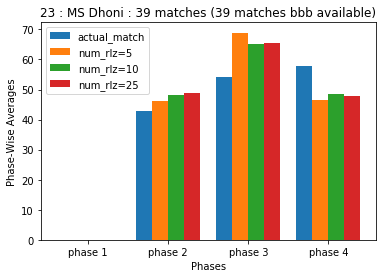

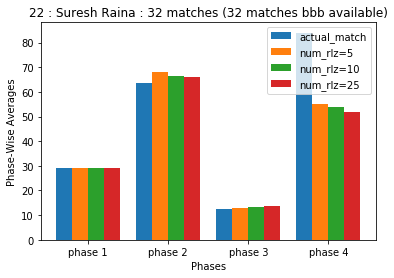

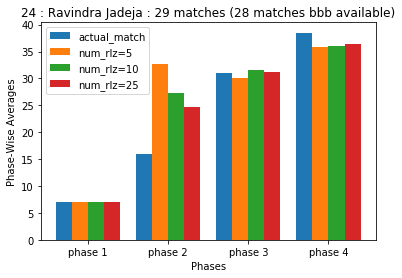

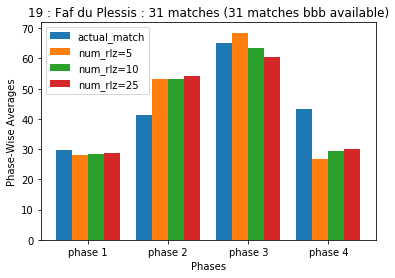

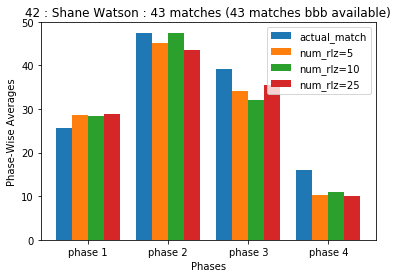

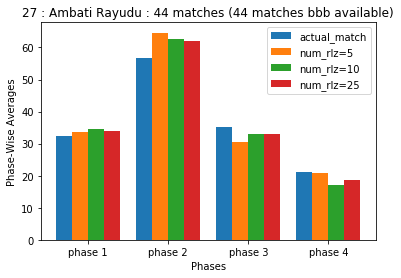

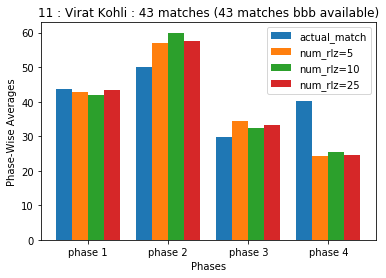

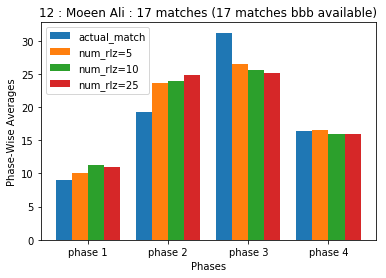

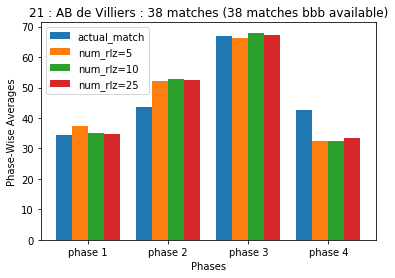

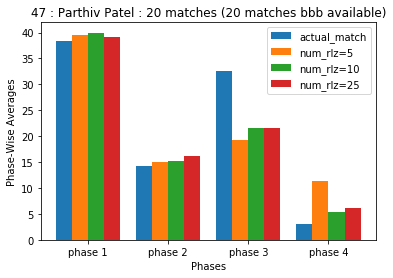

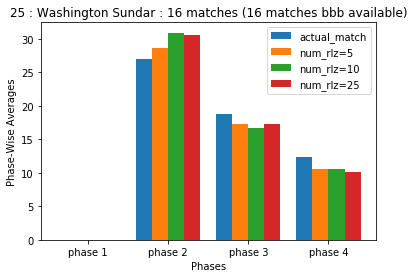

In [67]:
plot_ppwa(ppwa_true, ppwa_pred5, ppwa_pred10, ppwa_pred25, pmp_pred5, pmp)

### Plot phase-wise strike rates

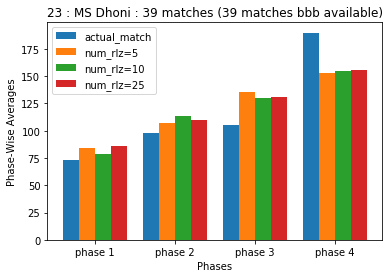

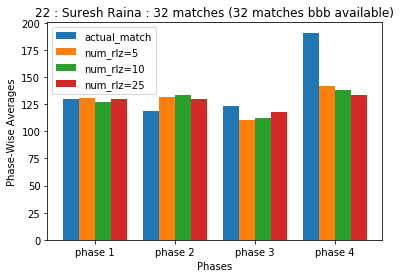

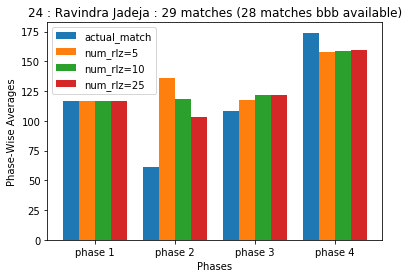

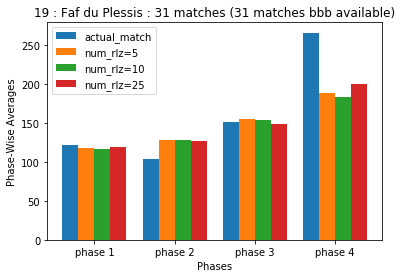

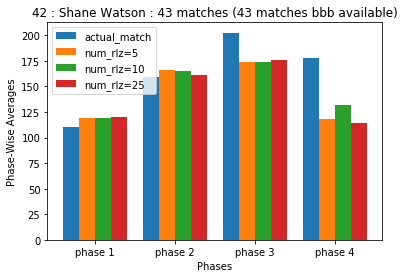

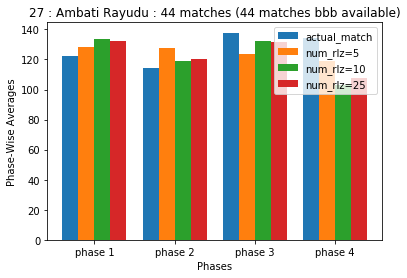

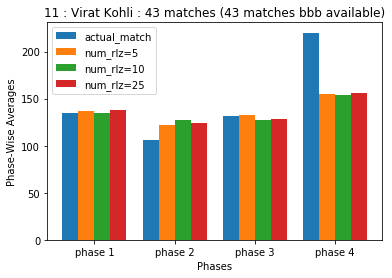

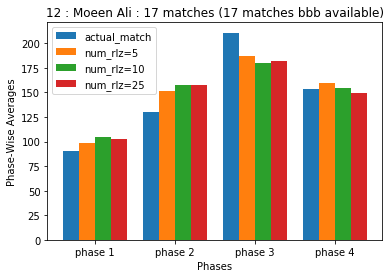

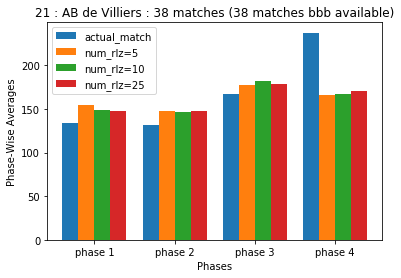

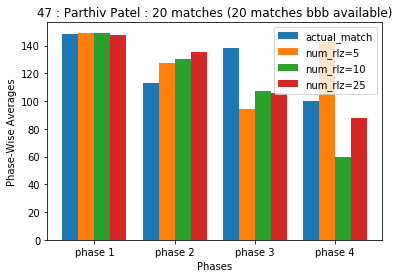

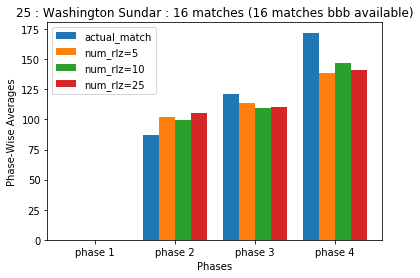

In [68]:
plot_ppwa(ppwsr_true, ppwsr_pred5, ppwsr_pred10, ppwsr_pred25, pmp_pred5, pmp)

## Testing on SMAT

### Set matches here

In [69]:
MATCHES_SMAT = range(1718, 2109)

### Define PHASES

In [70]:
PHASES = {1: (1,36),
          2: (37,66),
          3: (67,96),
          4: (97,120)
         }

### SMAT Players

In [71]:
TN_player_ids = [2097, 2334, 2332, 99, 2152, 2333, 97, 43]

Maha_player_ids = [194, 1, 46, 1910, 86, 1927]

Kar_player_ids = [166, 50, 2237, 2238, 226, 2236, 232, 196, 174]

Bar_player_ids = [2468, 143, 87, 1895, 1893, 1903]

OVERALL_SMAT_pids = TN_player_ids + Maha_player_ids + Kar_player_ids + Bar_player_ids

len(PID_TO_PNAME(OVERALL_SMAT_pids).keys())

29

### True results

In [78]:
res = compute_actual_phase_wise_averages_strikerates(MATCHES_SMAT, OVERALL_SMAT_pids)
ppwa_true_smat, ppwsr_true_smat, ppwr_true_smat, ppwd_true_smat, pmp_smat, num_error_matches = res[0], res[1], res[2], res[3], res[4], res[5]

100%|████████████████████████████████████████████████████████████| 391/391 [05:37<00:00,  1.16it/s]


### Predictions with num_rlz=1

In [79]:
ppwa_pred1_smat, ppwsr_pred1_smat, ppwr_pred1_smat, ppwd_pred1_smat, pmp_pred1_smat = compute_pred_phase_wise_averages_strikerates(MATCHES_SMAT, OVERALL_SMAT_pids, 1)

100%|████████████████████████████████████████████████████████████| 391/391 [06:48<00:00,  1.04s/it]


### Predictions with num_rlz=5

In [80]:
ppwa_pred5_smat, ppwsr_pred5_smat, ppwr_pred5_smat, ppwd_pred5_smat, pmp_pred5_smat = compute_pred_phase_wise_averages_strikerates(MATCHES_SMAT, OVERALL_SMAT_pids, 5)

100%|████████████████████████████████████████████████████████████| 391/391 [08:38<00:00,  1.33s/it]


### Predictions with num_rlz=10

In [81]:
ppwa_pred10_smat, ppwsr_pred10_smat, ppwr_pred10_smat, ppwd_pred10_smat, pmp_pred10_smat = compute_pred_phase_wise_averages_strikerates(MATCHES_SMAT, OVERALL_SMAT_pids, 10)

100%|████████████████████████████████████████████████████████████| 391/391 [15:17<00:00,  2.35s/it]


### Predictions with num_rlz=25

In [82]:
ppwa_pred25_smat, ppwsr_pred25_smat, ppwr_pred25_smat, ppwd_pred25_smat, pmp_pred25_smat = compute_pred_phase_wise_averages_strikerates(MATCHES_SMAT, OVERALL_SMAT_pids, 25)

100%|████████████████████████████████████████████████████████████| 391/391 [25:44<00:00,  3.95s/it]


### Plot phase-wise averages

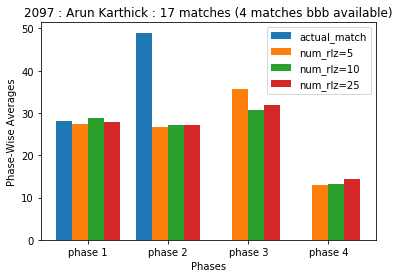

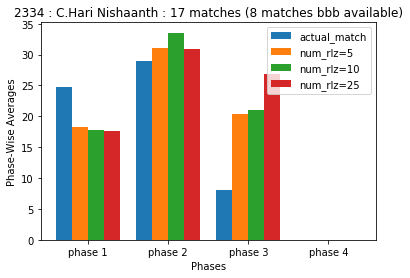

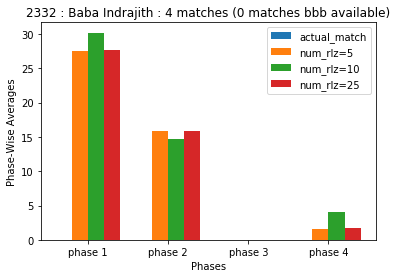

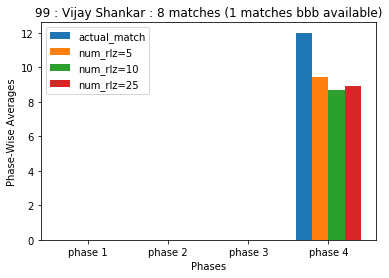

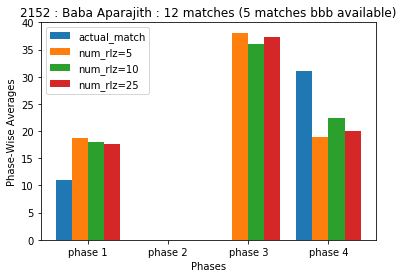

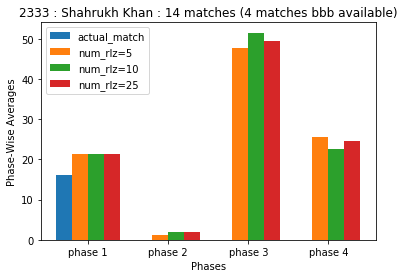

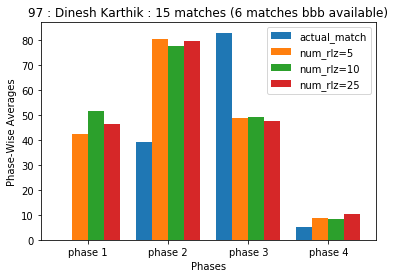

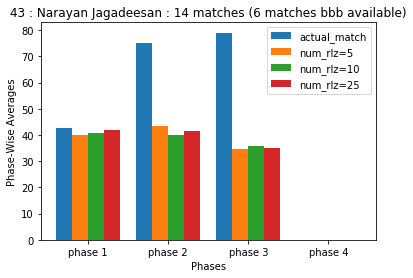

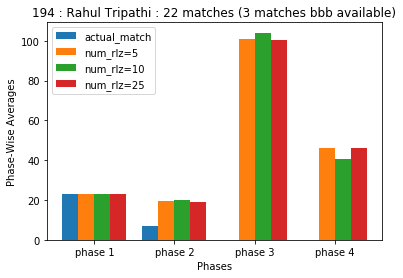

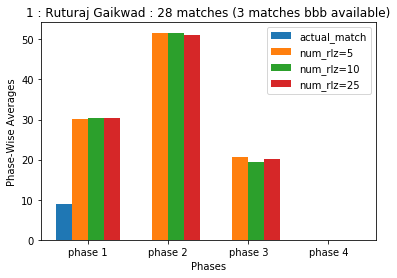

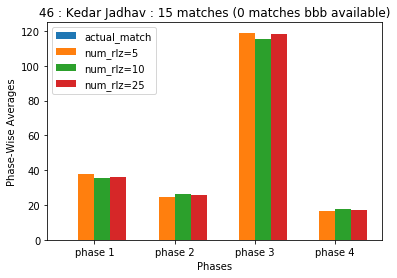

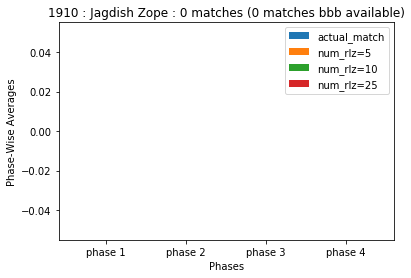

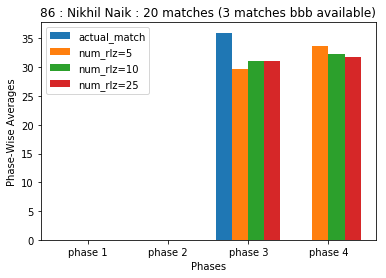

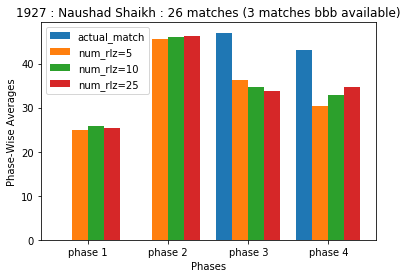

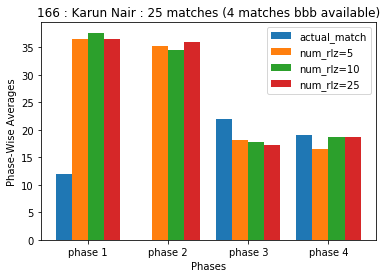

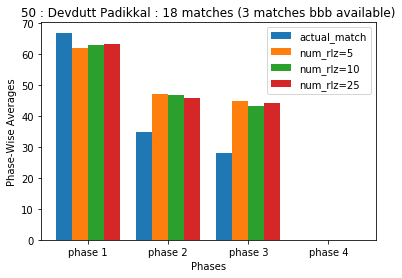

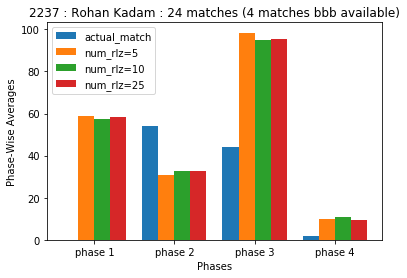

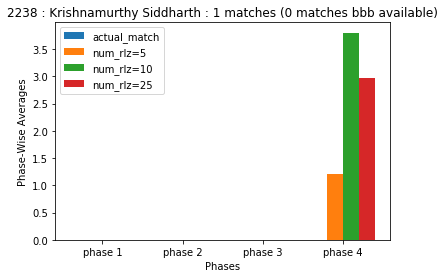

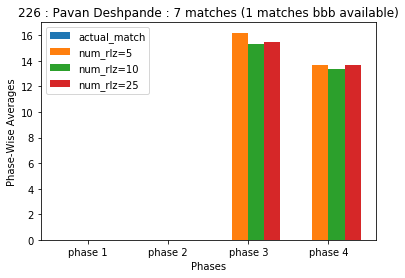

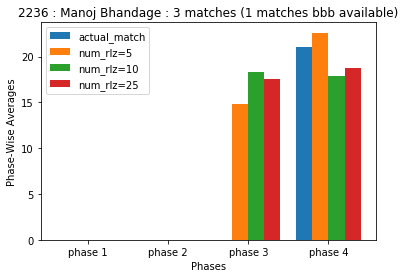

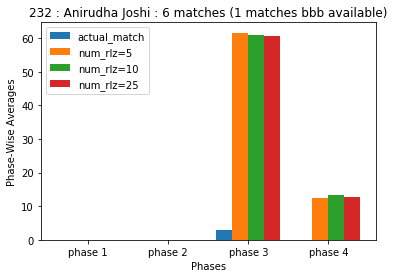

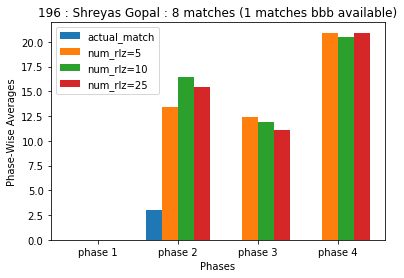

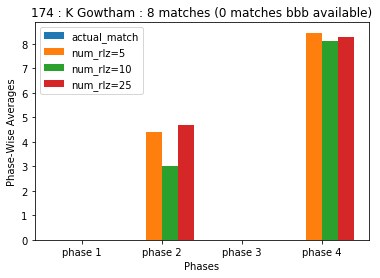

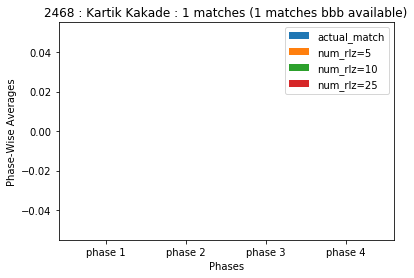

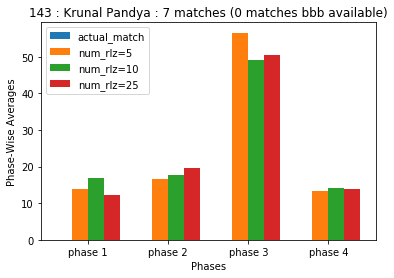

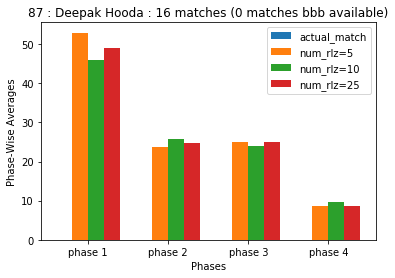

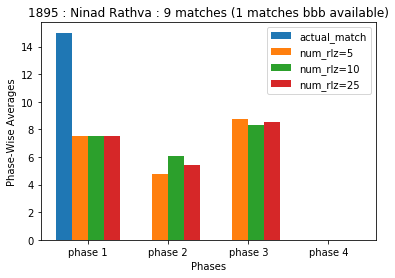

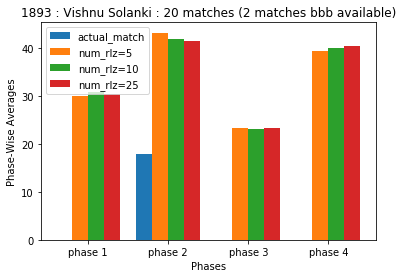

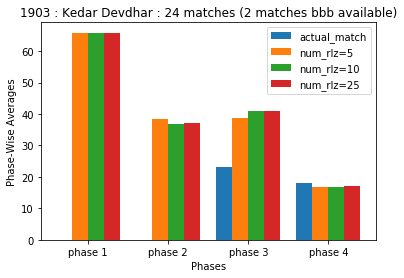

In [83]:
plot_ppwa(ppwa_true_smat, ppwa_pred5_smat, ppwa_pred10_smat, ppwa_pred25_smat, pmp_pred1_smat, pmp_smat)

### Plot phase-wise strike rates

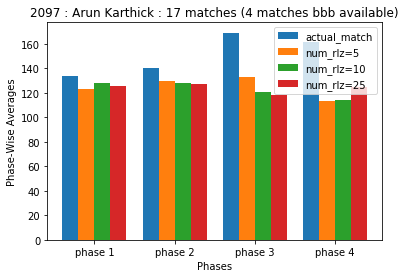

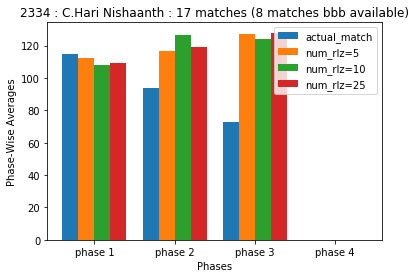

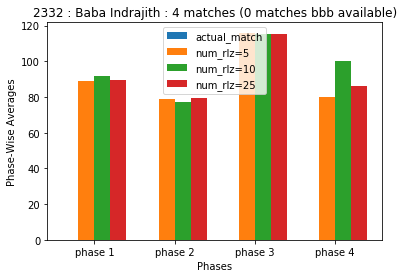

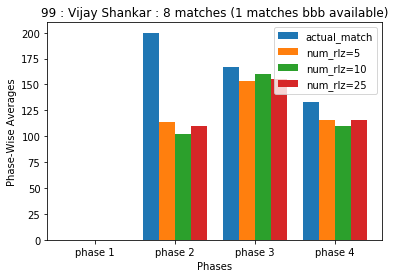

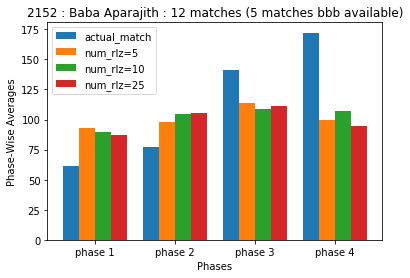

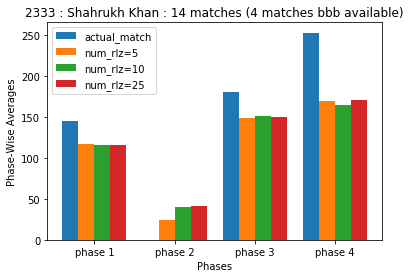

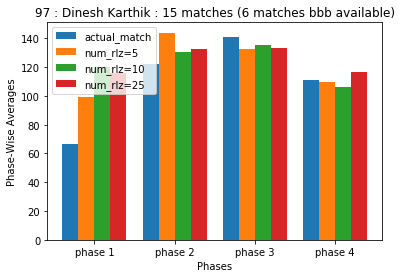

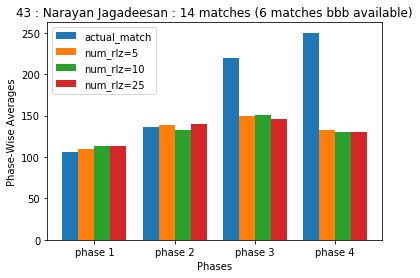

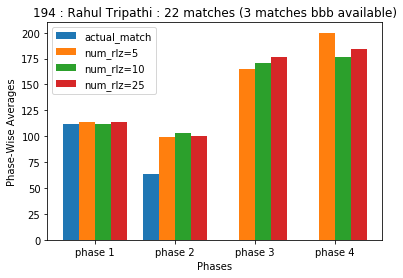

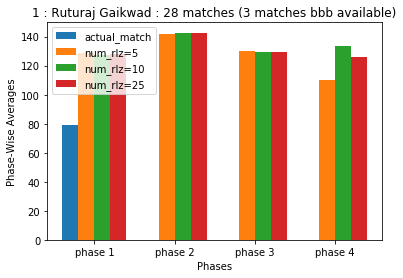

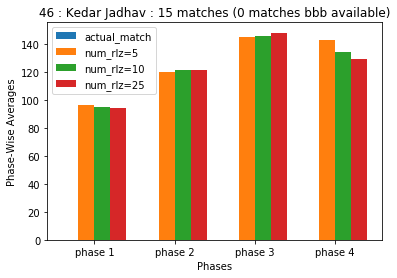

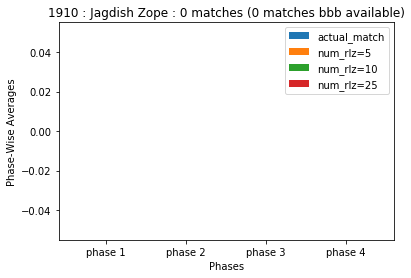

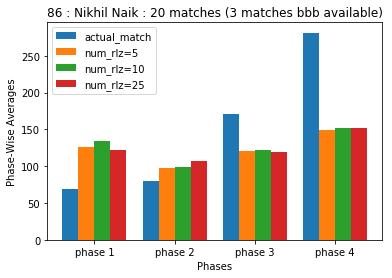

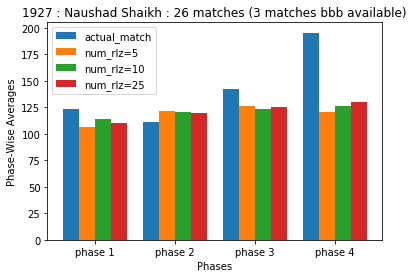

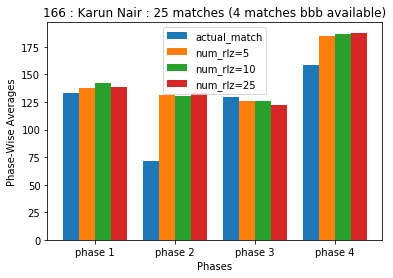

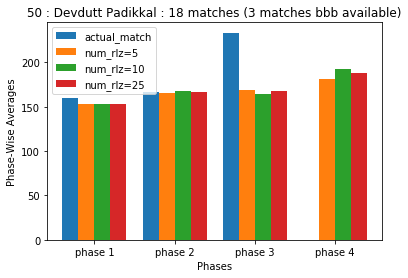

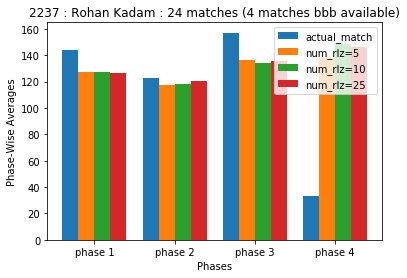

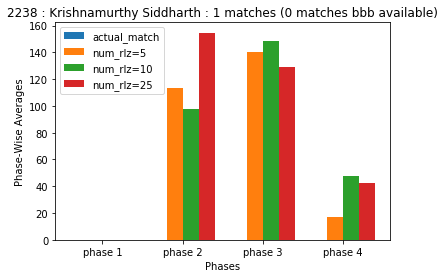

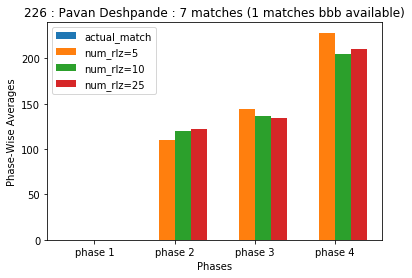

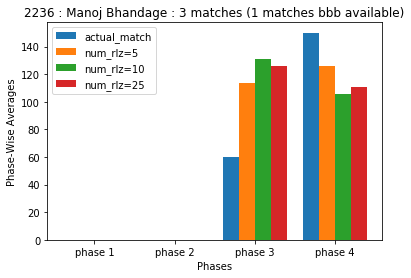

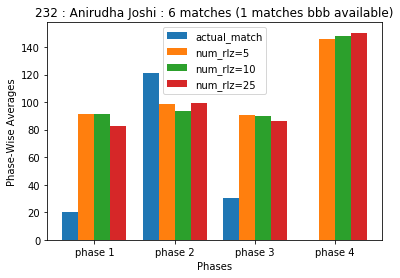

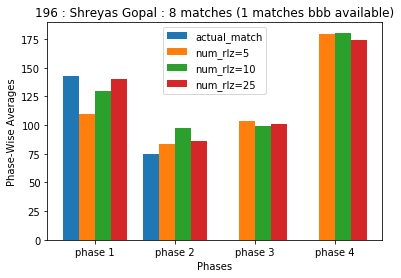

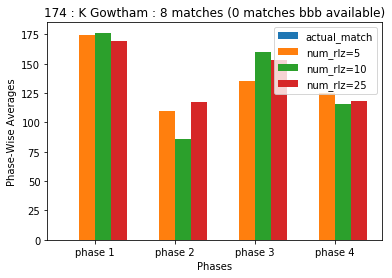

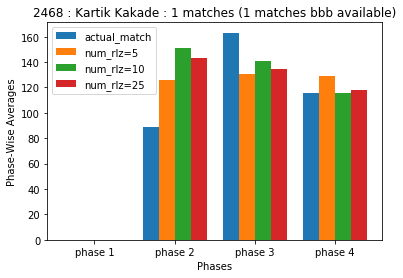

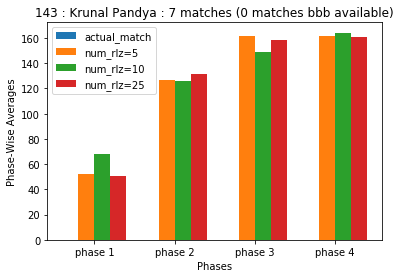

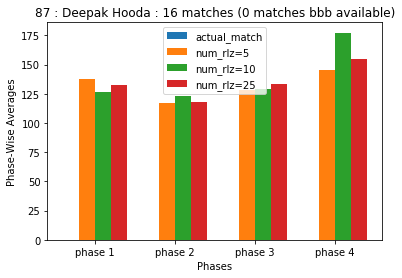

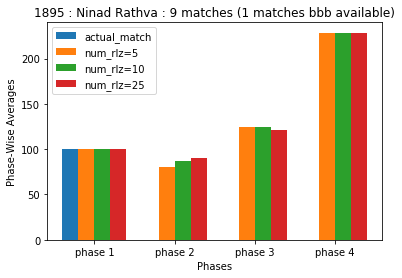

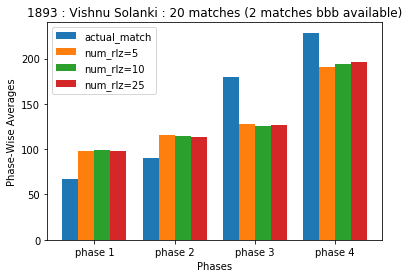

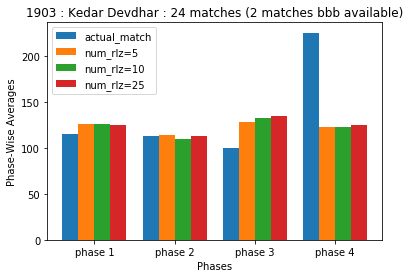

In [84]:
plot_ppwa(ppwsr_true_smat, ppwsr_pred5_smat, ppwsr_pred10_smat, ppwsr_pred25_smat, pmp_pred1_smat, pmp_smat)